#            Brain tumor (multi-class) classification from MRI images

# Importing Libraries

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import random
import tensorflow as tf
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
base_path = r'C:\Users\gjsat\Desktop\Final year Project\brain-tumor-classification'
labels = ['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [3]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 32
VERBOSE = 1

# Data Exploration

# LOADING THE DATASETS

In [4]:
x_train=[]
y_train=[]
for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'Training'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
print('Training dataset Loading complete.')

# Dataset from the testing folder..

for i in labels:
    folderPath = os.path.join(os.path.join(base_path,'Testing'),i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
        x_train.append(img)
        y_train.append(i)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)

print('Testing dataset Loading complete.')

 13%|█▎        | 14/105 [00:00<00:00, 137.80it/s]

Training dataset Loading complete.


100%|██████████| 100/100 [00:01<00:00, 91.17it/s]


Testing dataset Loading complete.


# Disease statistics visualization

C:\Users\gjsat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


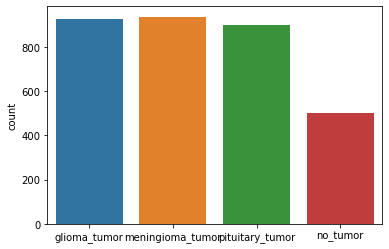

In [5]:
sns.countplot(y_train)
plt.show()

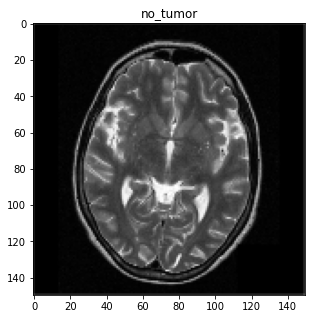

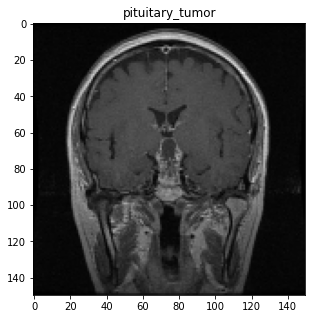

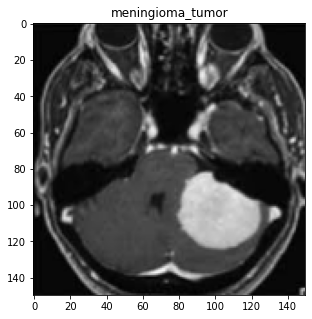

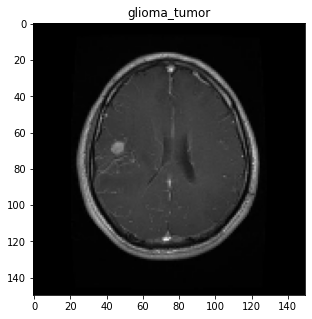

In [6]:
j=0
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            plt.figure(figsize = (5,5))
            plt.imshow(x_train[j])
            plt.title(y_train[j])
            break
        j+=1

In [7]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True, vertical_flip=False
)

datagen.fit(x_train)
x_train.shape

(3264, 150, 150, 3)

# Splitting the dataset for Testing
Here Dataset is divided into 90:10 ratio
    #90%=Training dataset
    #10%=Testing dataset

In [8]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.10, random_state=0)

print("Shapes X : Train :",x_train.shape,  " Test :",x_test.shape)
print("Shapes Y : Train :",y_train.shape,  " Test :",y_test.shape)

Shapes X : Train : (2937, 150, 150, 3)  Test : (327, 150, 150, 3)
Shapes Y : Train : (2937,)  Test : (327,)


# One-Hot Encoding
Encoding the y_train and y_test to numbers.
One-hot Encoding:It is one method of converting data to prepare it for an algorithm and get a better prediction.

In [9]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# Training the model

# CONVOLUTIONAL NEURAL NETWORKS(CNN):
    CNN is a class of deep neural networks, most commonly applied to analyze visual imagery.

# EfficientNetB0 MODEL

In [25]:
# Constants
IMAGE_SIZE = 150
BATCH_SIZE = 32
VERBOSE = 1

In [26]:
from tensorflow.keras.applications import EfficientNetB0
effnet = EfficientNetB0(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

In [27]:
# Adding Top Layers.
model1 = effnet.output
model1 = tf.keras.layers.GlobalAveragePooling2D()(model1)
model1 = tf.keras.layers.Dropout(0.5)(model1)
model1 = tf.keras.layers.Dense(4, activation = 'softmax')(model1)
model1 = tf.keras.models.Model(inputs = effnet.input, outputs = model1)

In [28]:
model1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 150, 150, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 150, 150, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [29]:
#compiling the model
model1.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [10]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

In [31]:
# Fitting the model
history1 = model1.fit(x_train, y_train, validation_split=0.1, epochs = 12, verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint,reduce_lr])

C:\Users\gjsat\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/12
83/83 [==============================] - 405s 5s/step - loss: 0.4834 - accuracy: 0.8161 - val_loss: 0.4319 - val_accuracy: 0.8844

Epoch 00001: val_accuracy improved from -inf to 0.88435, saving model to effnet.h5
Epoch 2/12
83/83 [==============================] - 362s 4s/step - loss: 0.1856 - accuracy: 0.9402 - val_loss: 0.3796 - val_accuracy: 0.9150

Epoch 00002: val_accuracy improved from 0.88435 to 0.91497, saving model to effnet.h5
Epoch 3/12
83/83 [==============================] - 359s 4s/step - loss: 0.1172 - accuracy: 0.9633 - val_loss: 0.2136 - val_accuracy: 0.9252

Epoch 00003: val_accuracy improved from 0.91497 to 0.92517, saving model to effnet.h5
Epoch 4/12
83/83 [==============================] - 361s 4s/step - loss: 0.0872 - accuracy: 0.9720 - val_loss: 0.3447 - val_accuracy: 0.9014

Epoch 00004: val_accuracy did not improve from 0.92517
Epoch 5/12
83/83 [==============================] - 356s 4s/step - loss: 0.0766 - accuracy: 0.9728 - val_loss: 0.2273 - va

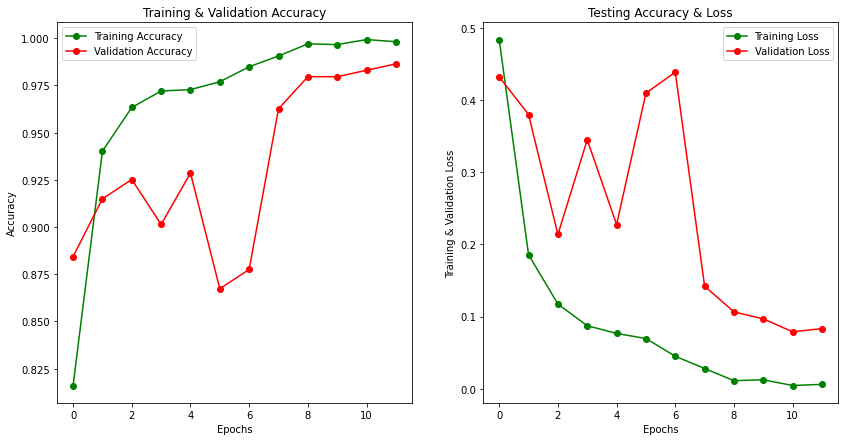

In [33]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
val_acc = history1.history['val_accuracy']
val_loss = history1.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Training Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

Model evaluation

In [34]:
result1=model1.evaluate(x_test, y_test)
print("Testing Loss :", result1[0])
print("Testing Accuracy :", result1[1]*100, "%")

11/11 [==============================] - 10s 884ms/step - loss: 0.0393 - accuracy: 0.9878
Testing Loss : 0.03932330757379532
Testing Accuracy : 98.77675771713257 %


In [35]:
predictions1 = model1.predict(x_test)
predictions1 = np.argmax(predictions1, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

In [36]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions1 )
print(cf_report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        54
           1       1.00      0.99      1.00       103
           2       0.98      0.98      0.98        82
           3       0.98      0.99      0.98        88

    accuracy                           0.99       327
   macro avg       0.99      0.99      0.99       327
weighted avg       0.99      0.99      0.99       327



<AxesSubplot:>

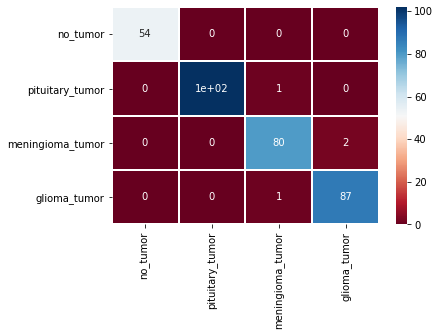

In [39]:
#confusion matrix
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions1)
sns.heatmap(cf_matrix, cmap = 'RdBu', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

# Xception MODEL

In [44]:
from tensorflow.keras.applications import Xception
xception = Xception(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

In [45]:
# Adding Top Layers.
model2 = xception.output
model2 = tf.keras.layers.GlobalAveragePooling2D()(model2)
model2 = tf.keras.layers.Dropout(0.5)(model2)
model2 = tf.keras.layers.Dense(4, activation = 'softmax')(model2)
model2 = tf.keras.models.Model(inputs = xception.input, outputs = model2)

In [46]:
# Summary of the model.
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [47]:
# Compiling the model.
model2.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [48]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("xception.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

# Training the Model

In [49]:
# Fitting the model
history2 = model2.fit(x_train, y_train, validation_split=0.1,epochs = 12,  verbose = VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

C:\Users\gjsat\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/12
83/83 [==============================] - 826s 10s/step - loss: 0.5477 - accuracy: 0.7930 - val_loss: 5.6622 - val_accuracy: 0.3129

Epoch 00001: val_accuracy improved from -inf to 0.31293, saving model to xception.h5
Epoch 2/12
83/83 [==============================] - 842s 10s/step - loss: 0.2434 - accuracy: 0.9168 - val_loss: 2.4372 - val_accuracy: 0.5918

Epoch 00002: val_accuracy improved from 0.31293 to 0.59184, saving model to xception.h5
Epoch 3/12
83/83 [==============================] - 1004s 12s/step - loss: 0.1729 - accuracy: 0.9451 - val_loss: 0.5643 - val_accuracy: 0.8197

Epoch 00003: val_accuracy improved from 0.59184 to 0.81973, saving model to xception.h5
Epoch 4/12
83/83 [==============================] - 812s 10s/step - loss: 0.1104 - accuracy: 0.9629 - val_loss: 0.4587 - val_accuracy: 0.8571

Epoch 00004: val_accuracy improved from 0.81973 to 0.85714, saving model to xception.h5
Epoch 5/12
83/83 [==============================] - 780s 9s/step - loss: 0.069

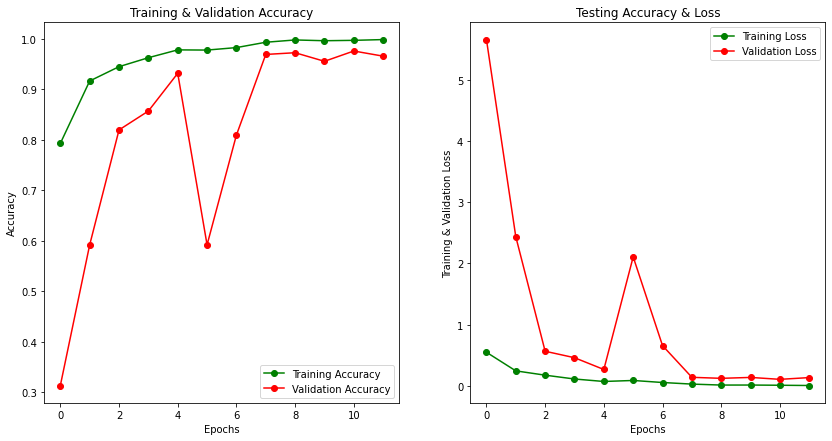

In [50]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'go-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'g-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

In [51]:
# Evaluating Model.
result2=model2.evaluate(x_test, y_test)
print("Testing Loss :", result2[0])
print("Testing Accuracy :", result2[1]*100, "%")

11/11 [==============================] - 16s 1s/step - loss: 0.1053 - accuracy: 0.9694
Testing Loss : 0.10531575232744217
Testing Accuracy : 96.94189429283142 %


In [53]:
predictions2 = model2.predict(x_test)
predictions2 = np.argmax(predictions2, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

In [54]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions2 )
print(cf_report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.99      0.98      0.99       103
           2       0.96      0.94      0.95        82
           3       0.93      0.98      0.96        88

    accuracy                           0.97       327
   macro avg       0.97      0.97      0.97       327
weighted avg       0.97      0.97      0.97       327



<AxesSubplot:>

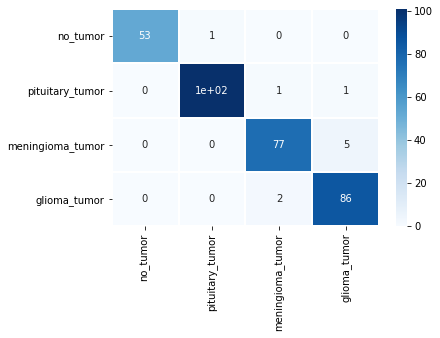

In [55]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions2)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

# MobileNet MODEL

In [10]:
# Importing the model and initializing.
from tensorflow.keras.applications.mobilenet import MobileNet
mblnt = MobileNet(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

17227776/17225924 [==============================] - 6s 0us/step


In [11]:
# Adding Top Layers.
model3 = mblnt.output
model3 = tf.keras.layers.GlobalAveragePooling2D()(model3)
model3 = tf.keras.layers.Dropout(0.5)(model3)
model3 = tf.keras.layers.Dense(4, activation = 'softmax')(model3)
model3 = tf.keras.models.Model(inputs = mblnt.input, outputs = model3)

In [12]:
model3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 75, 75, 32)        0     

In [13]:
model3.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("mblnt.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

In [16]:
# Fitting the model
history3 = model3.fit(x_train, y_train, validation_split=0.1, epochs = 12, verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

Epoch 1/12
83/83 [==============================] - 233s 3s/step - loss: 0.7615 - accuracy: 0.7911 - val_loss: 1.7150 - val_accuracy: 0.7381

Epoch 00001: val_accuracy improved from -inf to 0.73810, saving model to mblnt.h5
Epoch 2/12
83/83 [==============================] - 213s 3s/step - loss: 0.2652 - accuracy: 0.9134 - val_loss: 1.1222 - val_accuracy: 0.7959

Epoch 00002: val_accuracy improved from 0.73810 to 0.79592, saving model to mblnt.h5
Epoch 3/12
83/83 [==============================] - 202s 2s/step - loss: 0.1432 - accuracy: 0.9531 - val_loss: 0.4630 - val_accuracy: 0.8707

Epoch 00003: val_accuracy improved from 0.79592 to 0.87075, saving model to mblnt.h5
Epoch 4/12
83/83 [==============================] - 201s 2s/step - loss: 0.0995 - accuracy: 0.9705 - val_loss: 0.4658 - val_accuracy: 0.8980

Epoch 00004: val_accuracy improved from 0.87075 to 0.89796, saving model to mblnt.h5
Epoch 5/12
83/83 [==============================] - 204s 2s/step - loss: 0.1274 - accuracy: 0.9

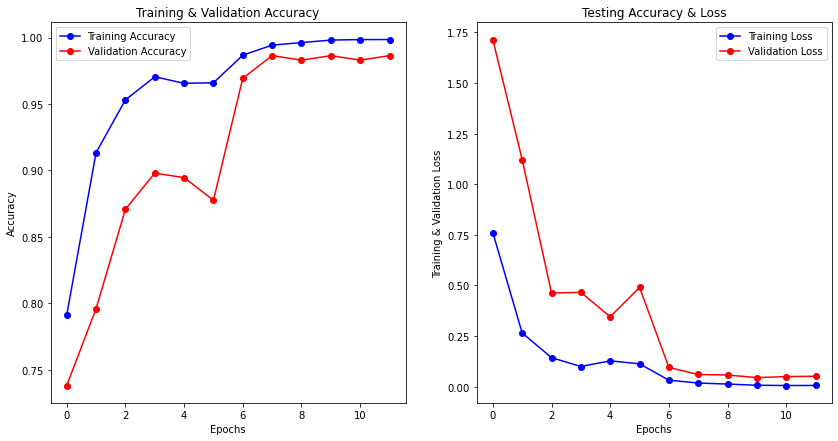

In [19]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history3.history['accuracy']
train_loss = history3.history['loss']
val_acc = history3.history['val_accuracy']
val_loss = history3.history['val_loss']
fig.set_size_inches(14, 7)

ax[0].plot(epochs, train_acc, 'bo-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'b-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

In [21]:
# Evaluating Model.
result3=model3.evaluate(x_test, y_test)
print("Testing Loss :", result3[0])
print("Testing Accuracy :", result3[1]*100, "%")

11/11 [==============================] - 5s 419ms/step - loss: 0.0340 - accuracy: 0.9847
Testing Loss : 0.033989809453487396
Testing Accuracy : 98.47095012664795 %


In [22]:
predictions3 = model3.predict(x_test)
predictions3 = np.argmax(predictions3, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

In [23]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions3 )
print(cf_report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        54
           1       0.98      0.99      0.99       103
           2       0.98      0.98      0.98        82
           3       0.99      0.99      0.99        88

    accuracy                           0.98       327
   macro avg       0.99      0.98      0.99       327
weighted avg       0.98      0.98      0.98       327



<AxesSubplot:>

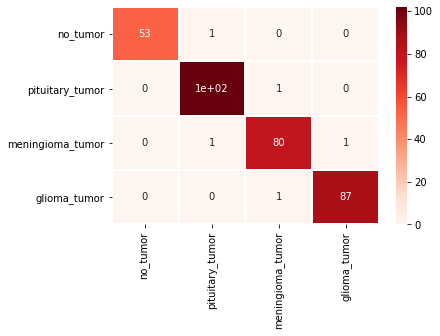

In [25]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions3)
sns.heatmap(cf_matrix, cmap = 'Reds', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)

# ResNet50 MODEL

In [26]:
# Importing the model and initializing.
from tensorflow.keras.applications.resnet import ResNet50
rsnet = ResNet50(weights = 'imagenet',include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE, 3))

94773248/94765736 [==============================] - 28s 0us/step


In [27]:
# Adding Top Layers.
model4 = rsnet.output
model4 = tf.keras.layers.GlobalAveragePooling2D()(model4)
model4 = tf.keras.layers.Dropout(0.5)(model4)
model4 = tf.keras.layers.Dense(4, activation = 'softmax')(model4)
model4 = tf.keras.models.Model(inputs = rsnet.input, outputs = model4)

In [28]:
# Summary of the model.
model4.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [29]:
# Compiling Model
model4.compile(loss = 'categorical_crossentropy', optimizer ='Adam', metrics=['accuracy'])

In [30]:
# Callbacks.
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("rsnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,mode='auto',verbose=VERBOSE)

In [31]:
# Fitting the model
history4 = model4.fit(x_train, y_train,  validation_split=0.1,epochs = 12,  verbose =VERBOSE, batch_size=BATCH_SIZE, callbacks=[tensorboard,checkpoint, reduce_lr])

C:\Users\gjsat\anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/12
83/83 [==============================] - 903s 11s/step - loss: 0.8556 - accuracy: 0.7333 - val_loss: 3651.4519 - val_accuracy: 0.2551

Epoch 00001: val_accuracy improved from -inf to 0.25510, saving model to rsnet.h5
Epoch 2/12
83/83 [==============================] - 816s 10s/step - loss: 0.3235 - accuracy: 0.8831 - val_loss: 20.0512 - val_accuracy: 0.6769

Epoch 00002: val_accuracy improved from 0.25510 to 0.67687, saving model to rsnet.h5
Epoch 3/12
83/83 [==============================] - 724s 9s/step - loss: 0.2021 - accuracy: 0.9308 - val_loss: 4.0284 - val_accuracy: 0.5374

Epoch 00003: val_accuracy did not improve from 0.67687
Epoch 4/12
83/83 [==============================] - 663s 8s/step - loss: 0.3411 - accuracy: 0.9024 - val_loss: 26.9704 - val_accuracy: 0.1735

Epoch 00004: val_accuracy did not improve from 0.67687

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/12
83/83 [==============================] - 1976s 24s/step 

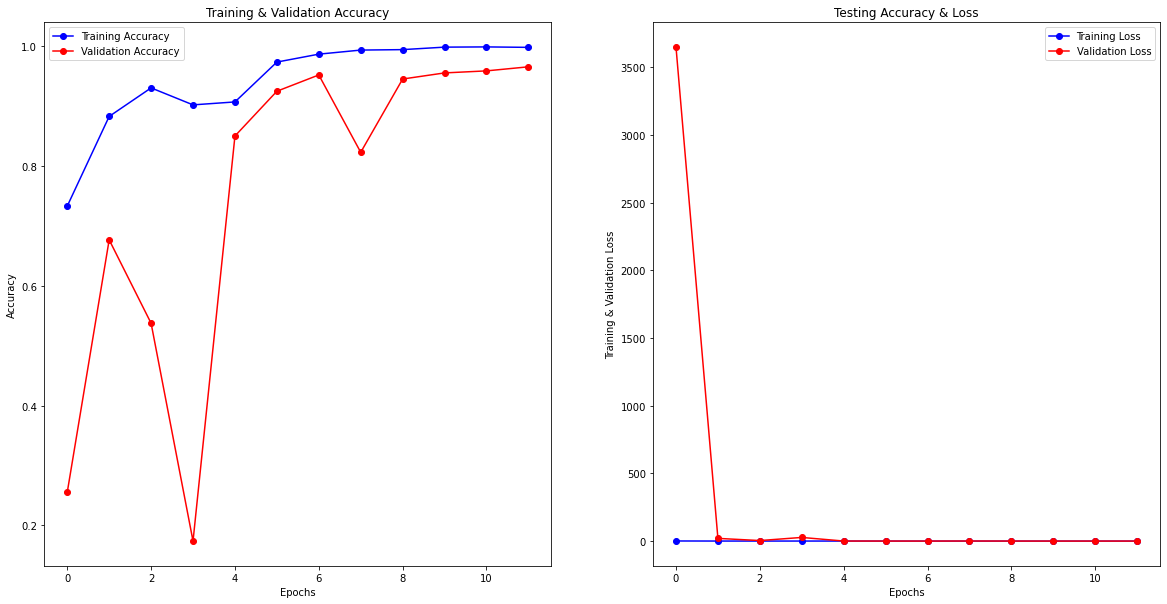

In [32]:
epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2)
train_acc = history4.history['accuracy']
train_loss = history4.history['loss']
val_acc = history4.history['val_accuracy']
val_loss = history4.history['val_loss']
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, 'bo-', label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, 'ro-', label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, train_loss, 'b-o', label ='Training Loss')
ax[1].plot(epochs, val_loss, 'r-o', label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')
plt.show()

In [33]:
# Evaluating Model.
result4=model4.evaluate(x_test, y_test)
print("Testing Loss :", result4[0])
print("Testing Accuracy :", result4[1]*100, "%")

11/11 [==============================] - 18s 2s/step - loss: 0.1297 - accuracy: 0.9450
Testing Loss : 0.12969346344470978
Testing Accuracy : 94.49541568756104 %


In [34]:
predictions4 = model4.predict(x_test)
predictions4 = np.argmax(predictions4, axis = 1)
y_test_edit = np.argmax(y_test , axis = 1)

In [35]:
# Classification report.
cf_report = sklearn.metrics.classification_report(y_test_edit, predictions4 )
print(cf_report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        54
           1       0.97      0.98      0.98       103
           2       0.94      0.88      0.91        82
           3       0.91      0.97      0.94        88

    accuracy                           0.94       327
   macro avg       0.95      0.94      0.94       327
weighted avg       0.95      0.94      0.94       327



<AxesSubplot:>

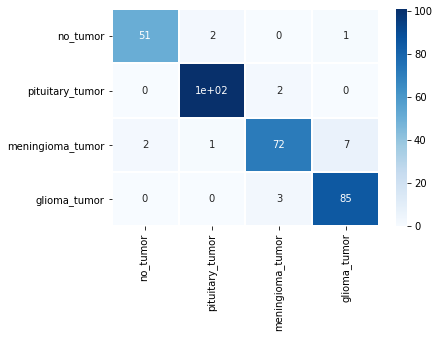

In [56]:
cf_matrix = sklearn.metrics.confusion_matrix(y_test_edit, predictions4)
sns.heatmap(cf_matrix, cmap = 'Blues', linewidth = 1, annot = True, xticklabels=labels, yticklabels=labels)